![](https://www.domsoria.com/wp-content/uploads/2019/11/keras.png)

# Deep Neural Network for Image Classification: Application

We will build a deep network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

In [1]:
# Import libraries
import time
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from utils.dnn_app_utils_v3 import *
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
import pydotplus, pydot


import skimage.transform
import imageio

%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## The dataset

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labelled as cat (1) or non-cat (0)
    - a test set of m_test images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


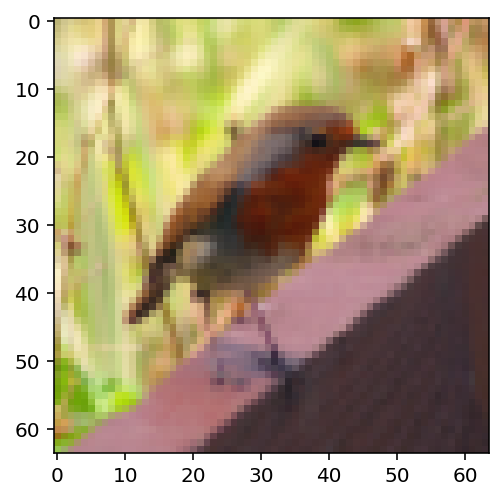

In [3]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

## The model

**Problem Statement**: How to create a neural network model in Keras? 

Well, there are several ways. Let's try to get familiar with a very intuitive one.

### A warm-up problem

Before classifiyin a cat image, we can study a simpler problem: classify whether a patient may be result in having diabete. The dataset describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years.

Attributes are numeric valued, so we can feed a neural network directly with them.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', header=None)
col_names = [   'NumberPregnant',
                'PlasmaGlucoseConc',
                'BloodPressure',
                'TricepsSkinThickness',
                'InsulinConc',
                'BMI',
                'DiabetesFunc',
                'Age',
                'Target']

df.columns = col_names

In [5]:
df

,NumberPregnant,PlasmaGlucoseConc,BloodPressure,TricepsSkinThickness,InsulinConc,BMI,DiabetesFunc,Age,Target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Models in Keras are defined as a sequence of layers.

We create a Sequential model and add layers one at a time until we are happy with our network architecture.
The first thing to get right is to ensure the input layer has the right number of input features. This can be specified when creating the first layer with the `input_dim` argument and setting it to $8$ for the $8$ input variables.

> How do we know the number of layers and their types?

This is a very hard question. 

__Here__: In this example, we will use a fully-connected network structure with three layers.

#### Activation Functions

Activation functions are functions used to get the output of a node

![](https://miro.medium.com/max/2724/1*E7ulOdTP-yekFGIJ8H8eVw.png)

it must be __non-linear__, indeed one can prove that a very deep network is equivalent to just one-node network if you use only linear activation functions.

__Commonly used activation functions__

![](https://miro.medium.com/max/1400/1*p_hyqAtyI8pbt2kEl6siOQ.png)

**General notes**

Briefly, functions that have a bit **flatter S** shape have better discriminatory power. The main reason why log-sigmoid and tanh are used is that their calculus derivatives, which are needed by the most common training algorithm back-propagation, are computationally convenient to compute.

*For this problem*: we use a three-layers network, with `relu` activation for the first two layers' units, while `sigmoid` for the output layer.

In [6]:
model = Sequential(name = 'diabete_model')
model.add(Dense(units=12, input_dim=8, activation = 'relu', name = 'first_layer'))
model.add(Dense(units=5, activation = 'relu', name = 'second_layer'))
model.add(Dense(units=1, activation = 'sigmoid', name = 'output_layer'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "diabete_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_layer (Dense)          (None, 12)                108       
_________________________________________________________________
second_layer (Dense)         (None, 5)                 65        
_________________________________________________________________
output_layer (Dense)         (None, 1)                 6         
Total params: 179
Trainable params: 179
Non-trainable params: 0
_________________________________________________________________


You can also visualise the model on a picture.

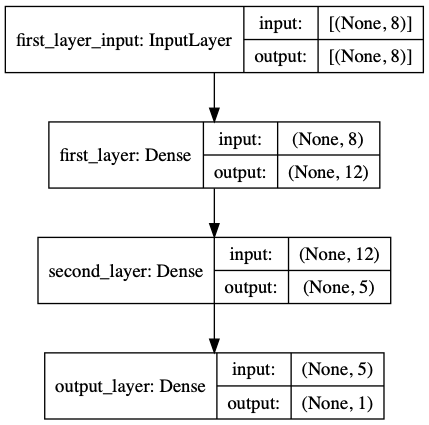

In [7]:
plot_model(model,show_shapes=True, show_layer_names=True)

`None` is there to indicate the number of training examples.
As one can see the model takes in a tensor of shape `(None, 8)`, since we have $8$ features.

We are now ready to prepare data to be fed in the model.

In [8]:
# Transform data into array
X = df[df.columns[:8]].values
Y = df[df.columns[-1]].values.reshape(-1,1)

Split into train and test set

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

X_val = X_train[:28]
Y_val = Y_train[:28]
X_train = X_train[28:]
Y_train = Y_train[28:]

<details>
<summary> <strong> Batches, epochs what are these? </strong> </summary>
<br>
Here a _hyper-super-insufficient_ note about batch size and epochs. 
I strongly encourage you to go and find details, starting from <a href="https://www.deeplearningbook.org/contents/optimization.html">here</a>.

#### Batches
First, what is a Batch?

In principle you can pass the entire dataset into the neural net at once. 
This is not advisable. 

<p align="center">
    <img src = "images/Batch-Man-image.png">
</p>

So, you divide dataset into a certain _Number of Batches_ or sets or parts.

**Note**: Batch size and number of batches are two different things.

This allows you to update parameters (calculatin gradients) over a small subset of the training one, speeding up computations.
The cost function to minimise is a sum over the batch of single-example costs.

$$ \mathcal{J}_b(\beta) = \sum_i^{N_b} J_i(\beta)\, .$$

Hence the update is averaged over the batch, not over the whole dataset.

There is of course a trade-off in the choice of the batch size ($N_b$). Too large makes you lose the effect of speeding up the computations (and evantually it may overfill the memory). Too small make the training too "noisy".

<p align="center">
    <img src = "https://miro.medium.com/max/908/1*bKSddSmLDaYszWllvQ3Z6A.png">
</p>

#### Epochs

> One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.

As said, since one epoch is often too big to feed to the computer at once we divide it in several smaller batches.

Why we use more than one Epoch? Since generally deep learning algorithms have a great number of parameters to fit, passing the entire dataset through a neural network once may be not enough. Hence, we need to pass the full dataset multiple times to the same neural network. But keep in mind that we are using a limited dataset and to optimise the learning and the graph we are using Gradient Descent which is an iterative process. So, updating the weights with single pass or one epoch is not enough.

As the number of epochs increases, more number of times the weight are changed in the neural network and the curve goes from underfitting to optimal to overfitting curve.

So, what is the right numbers of epochs? Unfortunately, there is no right answer to this question. As usual, there is a trade-off.

</details>

In [10]:
print('# Fit model on training data')
history = model.fit(X_train, Y_train,
                    batch_size=10,
                    epochs=150,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(X_val, Y_val))

print('\nhistory dict:', history.history)

# Fit model on training data
Epoch 1/150
67/67 [==============================] - 1s 14ms/step - loss: 6.8124 - accuracy: 0.6462 - val_loss: 3.0648 - val_accuracy: 0.6786
Epoch 2/150
67/67 [==============================] - 0s 1ms/step - loss: 2.7743 - accuracy: 0.6378 - val_loss: 1.3793 - val_accuracy: 0.7143
Epoch 3/150
67/67 [==============================] - 0s 1ms/step - loss: 1.3626 - accuracy: 0.6164 - val_loss: 1.0125 - val_accuracy: 0.5714
Epoch 4/150
67/67 [==============================] - 0s 2ms/step - loss: 0.9705 - accuracy: 0.6038 - val_loss: 0.8418 - val_accuracy: 0.5357
Epoch 5/150
67/67 [==============================] - 0s 1ms/step - loss: 0.7838 - accuracy: 0.6193 - val_loss: 0.7409 - val_accuracy: 0.6071
Epoch 6/150
67/67 [==============================] - 0s 1ms/step - loss: 0.7849 - accuracy: 0.5348 - val_loss: 0.6995 - val_accuracy: 0.5714
Epoch 7/150
67/67 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.6051 - val_loss: 0.6788 - val_

#### Evaluate

In [11]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test)
print('test loss, test acc:', results)


# Evaluate on test data
3/3 [==============================] - 0s 983us/step - loss: 0.5881 - accuracy: 0.7403
test loss, test acc: [0.5881245732307434, 0.7402597665786743]


#### Predictions

The number one question I get asked is:

> After I train my model, how can I use it to make predictions on new data?

this is a great question. 

In [12]:
# make probability predictions with the model
new_patient = np.array([4.00e+00, 1.48e+02, 6.00e+01, 2.70e+01, 3.18e+02, 3.09e+01,
       1.50e-01, 2.90e+01]).reshape(1,-1)

prob_pred = model.predict(new_patient)

prediction = round(float(prob_pred[[0]]))

In [13]:
prob_pred

array([[0.52399886]], dtype=float32)

## Back to cats

In [14]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [15]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [16]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1)   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1)

# Standardize data to have feature values between 0 and 1.
train_x = (train_x_flatten/255.)
test_x = (test_x_flatten/255.)

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (209, 12288)
test_x's shape: (50, 12288)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

## The model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

###  L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Keras/Deep Learning methodology to build the model:
    1. Design the shape of your model
    2. Add layers to your `Sequential model`
    3. Train the parameters on the training set
    4. Use learnt parameters to make predictions on new data.

Let's now implement those two models!

In [17]:
n_x = 12288     # num_px * num_px * 3

In [18]:
def two_layer_model(n_units_1, n_units_2 = 1):
    """
        function to define a two-layer neural network model.
        
        Parameters:
        ----------
            - n_units_1 : int
                            number of hidden units of the first hidden layer.
                            
            - n_units_2 : int
                            number of hidden units of the second hidden layer.
                            
        Return:
        -------
            - model : Keras model object.
            
    """
    
    model = Sequential()
    model.add(Dense(n_units_1, input_dim=n_x, activation = 'tanh', kernel_initializer='uniform', name = 'first_hidden_layer'))
    model.add(Dense(n_units_2, activation = 'sigmoid', name = 'output_layer'))
    
    return model

In [19]:
model = two_layer_model(7)

In [20]:
opt = optimizers.Adam(lr = 1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 7)                 86023     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 8         
Total params: 86,031
Trainable params: 86,031
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_y = train_y.T

In [22]:
model.fit(train_x, train_y, batch_size=10, epochs=100)

Epoch 1/100
21/21 [==============================] - 0s 1ms/step - loss: 0.7582 - accuracy: 0.6251
Epoch 2/100
21/21 [==============================] - 0s 945us/step - loss: 0.6801 - accuracy: 0.6459
Epoch 3/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6328 - accuracy: 0.6916
Epoch 4/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6132 - accuracy: 0.6838
Epoch 5/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6384 - accuracy: 0.6644
Epoch 6/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.6092
Epoch 7/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6291 - accuracy: 0.6865
Epoch 8/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6127 - accuracy: 0.6843
Epoch 9/100
21/21 [==============================] - 0s 1ms/step - loss: 0.6211 - accuracy: 0.6839
Epoch 10/100
21/21 [==============================] - 0s 1ms/step - loss: 0.5889 - accuracy: 0.6808
Epoch 1

In [23]:
# Predictions on test set
model.predict(test_x)

array([[0.6385721 ],
       [0.5882786 ],
       [0.53800446],
       [0.6721021 ],
       [0.40055543],
       [0.37937778],
       [0.22094095],
       [0.5406891 ],
       [0.6832994 ],
       [0.550032  ],
       [0.63797843],
       [0.6193171 ],
       [0.57769907],
       [0.60179865],
       [0.22072285],
       [0.4799677 ],
       [0.25641093],
       [0.591292  ],
       [0.3788991 ],
       [0.30759668],
       [0.6357104 ],
       [0.22707641],
       [0.2597247 ],
       [0.6487716 ],
       [0.7078772 ],
       [0.66128457],
       [0.32737935],
       [0.31919032],
       [0.23946264],
       [0.52817446],
       [0.5851477 ],
       [0.5334261 ],
       [0.44647062],
       [0.6003163 ],
       [0.812114  ],
       [0.16763616],
       [0.16786188],
       [0.6151183 ],
       [0.23297223],
       [0.19716856],
       [0.40550396],
       [0.6807172 ],
       [0.49968615],
       [0.17378849],
       [0.40874162],
       [0.31520915],
       [0.24632975],
       [0.759

In [24]:
res = model.evaluate(test_x, test_y.T)
print('\n# Evaluate')
dict(zip(model.metrics_names, res))

2/2 [==============================] - 0s 1ms/step - loss: 0.6027 - accuracy: 0.7000

# Evaluate


{'loss': 0.6026753187179565, 'accuracy': 0.699999988079071}

### L-layer model

In [25]:
def L_layer_model(n_layers, n_units, n_x):
    """
        function to define an L-layer neural network model.
        
        Parameters:
        ----------
            - n_layers : int
                            number of hidden layers + output layer.
                            
            - n_units :  list of int
                            number of hidden units of for each hidden layer.
                            
            - n_x : int
                        number of input features.
                            
        Return:
        -------
            - model : Keras model object.
            
    """
    
    model = Sequential()
    model.add(Dense(n_units[0], input_dim = n_x, activation = 'relu',  kernel_initializer='uniform')) # first layer
    for l in range(1,n_layers):
        if l == n_layers-1:
            model.add(Dropout(rate=0.2))
            model.add(Dense(n_units[l], activation = 'sigmoid', name = 'output_layer')) # output layer
        else:
            model.add(Dense(n_units[l], activation = 'relu', name = 'hidden_layer_' + str(l)))
        
    return model

In [26]:
n_layers = 3
n_units = [17, 7, 1]

model = L_layer_model(n_layers, n_units, n_x)

In [27]:
opt = optimizers.Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                208913    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 7)                 126       
_________________________________________________________________
dropout (Dropout)            (None, 7)                 0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 8         
Total params: 209,047
Trainable params: 209,047
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(train_x, train_y, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
6/6 [==============================] - 0s 28ms/step - loss: 0.6955 - accuracy: 0.6151 - val_loss: 0.6147 - val_accuracy: 0.7143
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6790 - accuracy: 0.5909 - val_loss: 0.6108 - val_accuracy: 0.7143
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6208 - accuracy: 0.6659 - val_loss: 0.5851 - val_accuracy: 0.7143
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.6421 - accuracy: 0.6235 - val_loss: 0.6029 - val_accuracy: 0.7143
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 0.6297 - accuracy: 0.6203 - val_loss: 0.5933 - val_accuracy: 0.7143
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5893 - accuracy: 0.6566 - val_loss: 0.6026 - val_accuracy: 0.7143
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5957 - accuracy: 0.6767 - val_loss: 0.5886 - val_accuracy: 0.7143
Epoch 8/100
6/6 [=========

## Learning Curves

__Question__: How to use Learning Curves to Diagnose Machine Learning Model Performance?

This lecture aim is to define and study an important tool for diagnostic of a machine learning algorithm: __learning curves__.

> A learning curve is a plot of model learning performance over experience or time.

In other words, one can say that _Learning Curves_ provide a mathematical representation of the learning process that takes place as task repetition occurs.

The model can be evaluated on the training dataset and on a hold out validation dataset after each update during training and plots of the measured performance can created to show learning curves.

Reviewing learning curves of models during training can be used to diagnose problems with learning, such as an underfit or overfit model, as well as whether the training and validation datasets are suitably representative.

An interesting, but quite technical, reading may be found [here](https://www.sciencedirect.com/science/article/abs/pii/S016981411100062X).

First of all we need to choose a way to parametrise the learning performance. 
This is done through a metric. One can be, for instance, the learning accuracy, or precision, etc.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


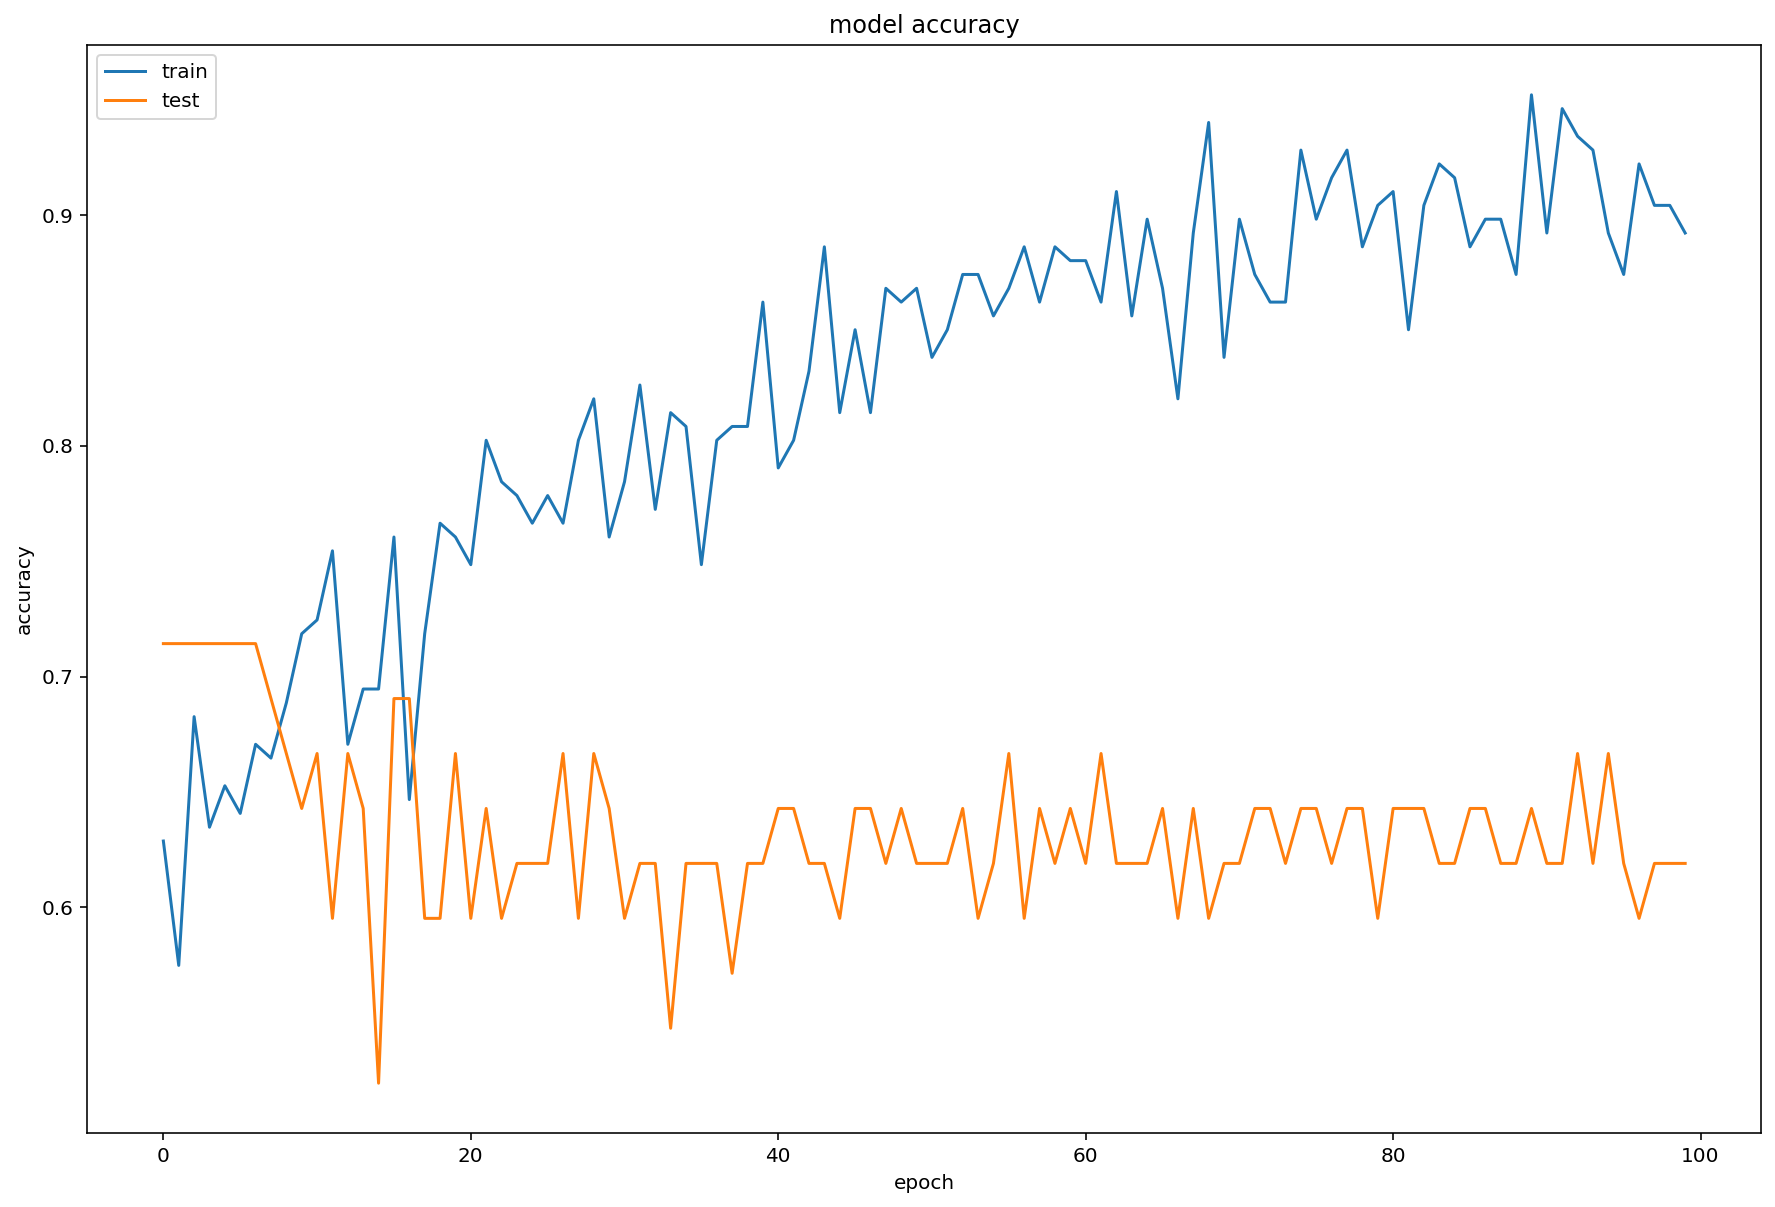

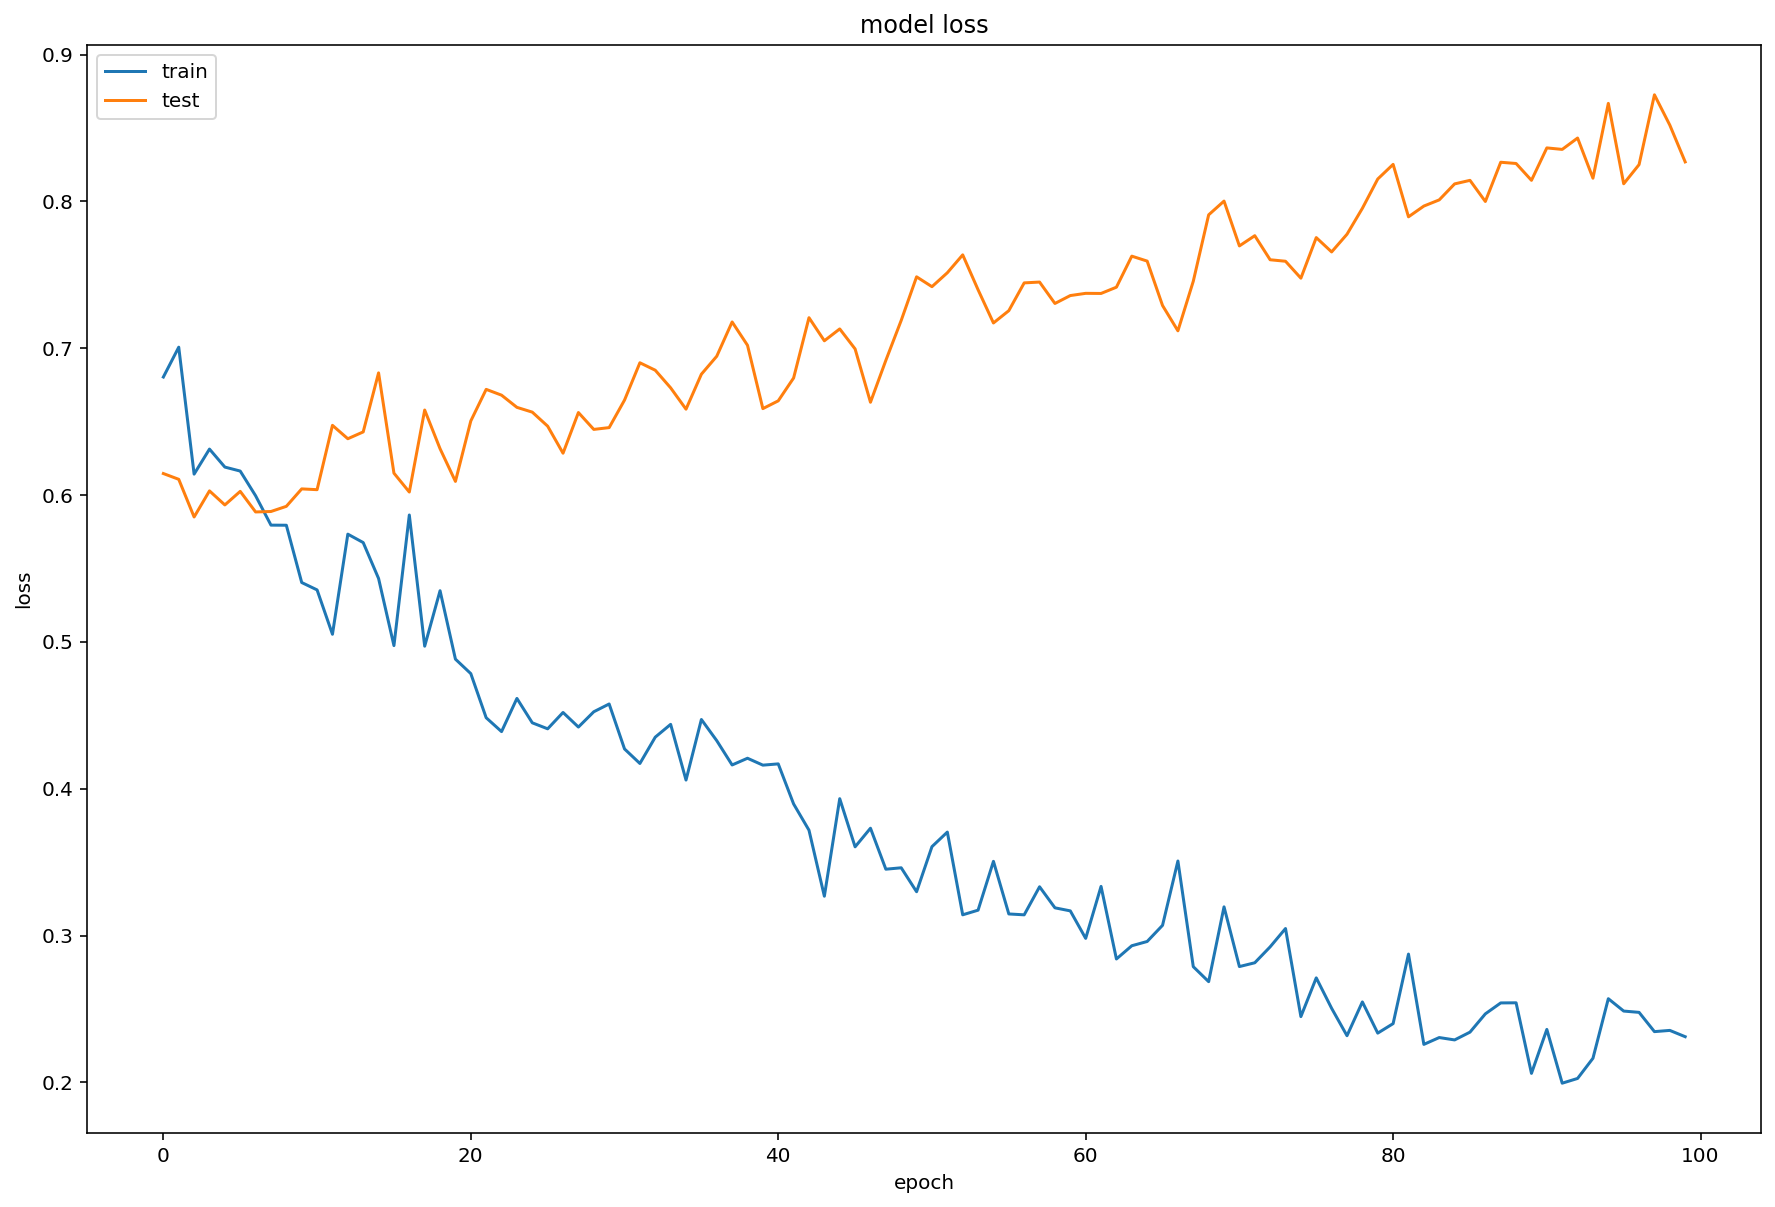

In [29]:
print(history.history.keys())

plt.figure(figsize=(15,10))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
res = model.evaluate(test_x, test_y.T)
print('\n# Evaluate')
dict(zip(model.metrics_names, res))

2/2 [==============================] - 0s 2ms/step - loss: 0.7544 - accuracy: 0.7000

# Evaluate


{'loss': 0.7543652057647705, 'accuracy': 0.699999988079071}

You obtained a classifier for cat picture with a $70$% accuracy. 

## Test with your picture

y = 0.75204843, your L-layer model predicts a "cat" picture.


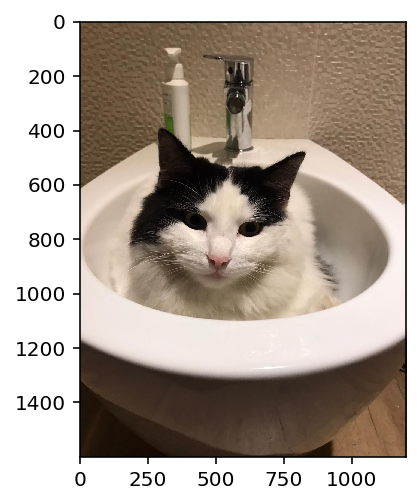

In [31]:
my_image = "Giampiero.jpeg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(imageio.imread(fname))
image = image/255.
my_image = skimage.transform.resize(image, (num_px,num_px)).reshape((1, num_px*num_px*3))
my_predicted_image = model.predict(my_image)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.round(my_predicted_image)),].decode("utf-8") +  "\" picture.")